In [1]:
!pip install gymnasium
!pip install "gymnasium[atari, accept-rom-license]"
!apt-get install -y swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.6 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446661 sha256=76781fe30abe600535a5bb2640951a2c2b29a79d3705a4644a36a030ac898356
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
 

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt

# Define the Deep Q-Learning model architecture
class Network(nn.Module):
    def __init__(self, state_size, action_size, seed=42):
        super(Network, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

# Define the Transformer model architecture
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, ff_dim, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, hidden_dim),
        )
        self.layernorm1 = nn.LayerNorm(hidden_dim)
        self.layernorm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.layernorm1(x + attn_output)
        ff_output = self.feed_forward(x)
        x = self.layernorm2(x + self.dropout(ff_output))
        return x

class TransformerModel(nn.Module):
    def __init__(self, state_size, action_size, hidden_dim=64, num_layers=2, num_heads=4, ff_dim=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(state_size, hidden_dim)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(hidden_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(hidden_dim, action_size)

    def forward(self, state):
        state = state.unsqueeze(1)  # Add a dummy sequence dimension
        x = self.embedding(state)
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, hidden_dim) -> (seq_len, batch_size, hidden_dim)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, hidden_dim) -> (batch_size, seq_len, hidden_dim)
        return self.fc(x[:, 0, :])

# Load the models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

state_size = 8  # State size for LunarLander-v2
action_size = 4  # Number of actions for LunarLander-v2

deep_q_model = Network(state_size, action_size).to(device)
transformer_model = TransformerModel(state_size, action_size).to(device)

deep_q_model.load_state_dict(torch.load('deep_q.pth'))
transformer_model.load_state_dict(torch.load('transformer.pth'))

deep_q_model.eval()
transformer_model.eval()

# Function to evaluate a model
def evaluate_model(model, env, num_episodes=100, max_timesteps=1000, success_threshold=200):
    episode_rewards = []
    num_successes = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        for _ in range(max_timesteps):
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            with torch.no_grad():
                action_values = model(state)
            action = np.argmax(action_values.cpu().data.numpy())
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            state = next_state
            if done:
                break
        episode_rewards.append(total_reward)
        if total_reward >= success_threshold:
            num_successes += 1
    success_rate = num_successes / num_episodes
    return episode_rewards, success_rate

env = gym.make('LunarLander-v2')

# Evaluate Deep Q-Learning model
deep_q_rewards, deep_q_success_rate = evaluate_model(deep_q_model, env)
deep_q_mean_reward = np.mean(deep_q_rewards)
deep_q_std_reward = np.std(deep_q_rewards)
print(f"RL Model - Mean Reward: {deep_q_mean_reward}, Std Dev: {deep_q_std_reward}, Success Rate: {deep_q_success_rate}")

# Evaluate Transformer model
transformer_rewards, transformer_success_rate = evaluate_model(transformer_model, env)
transformer_mean_reward = np.mean(transformer_rewards)
transformer_std_reward = np.std(transformer_rewards)
print(f"TRL Model - Mean Reward: {transformer_mean_reward}, Std Dev: {transformer_std_reward}, Success Rate: {transformer_success_rate}")


RL Model - Mean Reward: 208.21581031851446, Std Dev: 62.80995019644486, Success Rate: 0.64
TRL Model - Mean Reward: 225.41747747836897, Std Dev: 44.44218463002556, Success Rate: 0.81


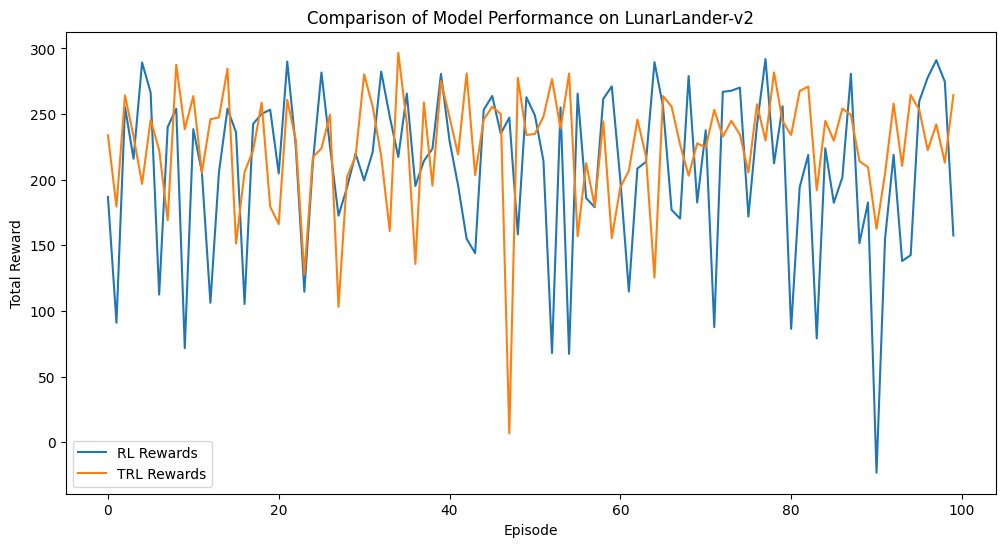

In [25]:
# Plotting the rewards for each episode
plt.figure(figsize=(12, 6))
plt.plot(deep_q_rewards, label='RL Rewards')
plt.plot(transformer_rewards, label='TRL Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Comparison of Model Performance on LunarLander-v2')
plt.legend()
plt.show()

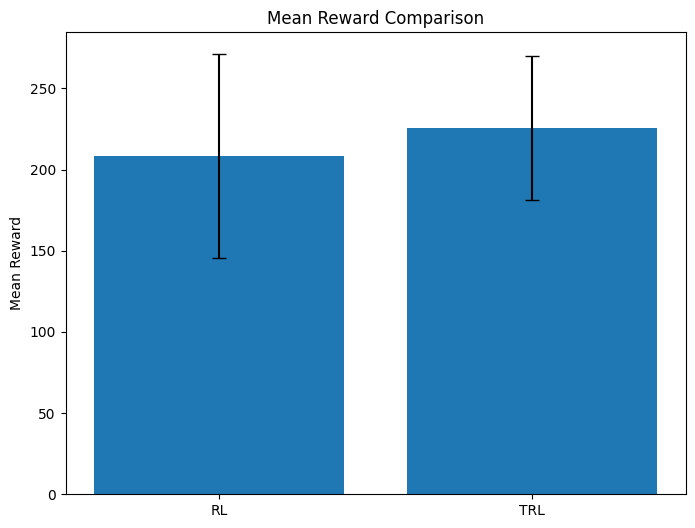

In [26]:
# Plotting the mean rewards
models = ['RL', 'TRL']
mean_rewards = [deep_q_mean_reward, transformer_mean_reward]
std_rewards = [deep_q_std_reward, transformer_std_reward]

plt.figure(figsize=(8, 6))
plt.bar(models, mean_rewards, yerr=std_rewards, capsize=5)
plt.ylabel('Mean Reward')
plt.title('Mean Reward Comparison')
plt.show()
